# NeurIPS data exploration: 
## Plan
- load the trajectories data
- calculate stats
- load proprio data. Identify mapping
- load annotations, index proprio and trajectories
- calc stats / trims against the skills.
- wrap into dataset loader with 1 hand (?) dof for training
- adjust ACT to ffed that data

Lessons learned:
data folder
```
Index(['index', 'episode_index', 'task_index', 'timestamp',
       'observation.state', 'observation.cam_rel_poses', 'action',
       'observation.task_info'],
      dtype='object')
observation.state: len=256
observation.cam_rel_poses: len=21
action: len=23
observation.task_info: len=46
```
```

  observation.state (256 dims):
  - Full R1Pro robot state: joints (positions/velocities/efforts), end-effectors, grippers
  - Includes restricted fields (global position, base state) marked "NOT allowed in standard track"

  action (23 dims):
  - [0:3] base (x, y, yaw)
  - [3:7] torso (4 joints)
  - [7:14] left arm (7 joints)
  - [14] left gripper
  - [15:22] right arm (7 joints)
  - [22] right gripper

  observation.cam_rel_poses (21 dims):
  - 3 cameras × 7 values (xyz position + wxyz quaternion)
  - Left wrist, right wrist, head cameras
```

Arm configs
```
  module:
    prop_dim: 26
    prop_keys:
      - qpos/left_arm
      - qpos/left_gripper
      - qpos/right_arm
      - qpos/right_gripper
      - eef/left_pos
      - eef/left_quat
      - eef/right_pos
      - eef/right_quat
    action_dim: 14
    action_keys: [left_arm, left_gripper, right_arm, right_gripper]
```

## TBD questions
 - observation.task_info len(46) - what's that?

In [5]:
# data/task-0000/episode_00003000.parquet
# meta - scene desdcribtion
# annotations - some with skill ID
# videos
ar = {
    "p_data": "/mnt/v/data/behavior-1k",
}

In [8]:
# parquet
import pandas as pd
import os
from pathlib import Path


def load_episode(p_data, task_id, episode_id):
    p_ep = Path(f"{p_data}/data/task-{task_id:04d}/episode_{episode_id:08d}.parquet")

    if not p_ep.exists():
        raise FileNotFoundError(f"no data episde {p_ep}")
    
    print(f"loading data {p_ep}")
    res = pd.read_parquet(p_ep)
    print(f"Success loading data {p_ep}")
    return res

test_ep = load_episode(ar['p_data'], 0, 10)
len(test_ep)


loading data /mnt/v/data/behavior-1k/data/task-0000/episode_00000010.parquet
Success loading data /mnt/v/data/behavior-1k/data/task-0000/episode_00000010.parquet


1956

In [34]:
def stats_col(data_col):
    import numpy as np
    import pandas as pd
    
    # Check first element
    first_elem = data_col.iloc[0]
    
    # Check if it's an array/list
    try:
        # Try to get length - will fail for scalars
        elem_len = len(first_elem)
        # It's an array column
        data = np.vstack(data_col.values)
        df = pd.DataFrame(data)
        result = df.describe()
        
        # Calculate mean_delta for each sub-column
        deltas = np.diff(data, axis=0).mean(axis=0)
        result.loc['mean_delta'] = deltas
        
    except TypeError:
        # It's a scalar column
        result = data_col.describe()
        
        # Calculate mean_delta for scalar column
        mean_delta = data_col.diff().mean()
        result['mean_delta'] = mean_delta
        

    

    return result

print(test_ep.columns)
for c in test_ep.columns:
    print(f"============{c}============")
    print(stats_col(test_ep[c]))
    try:
        l = len(test_ep[c][1])
        print(f"{c}: len={l}")
    except Exception:
        pass



Index(['index', 'episode_index', 'task_index', 'timestamp',
       'observation.state', 'observation.cam_rel_poses', 'action',
       'observation.task_info'],
      dtype='object')
============index============
count         1956.000000
mean           977.500000
std            564.792882
min              0.000000
25%            488.750000
50%            977.500000
75%           1466.250000
max           1955.000000
mean_delta       1.000000
Name: index, dtype: float64
============episode_index============
count         1956.0
mean            10.0
std              0.0
min             10.0
25%             10.0
50%             10.0
75%             10.0
max             10.0
mean_delta       0.0
Name: episode_index, dtype: float64
============task_index============
count         1956.0
mean             0.0
std              0.0
min              0.0
25%              0.0
50%              0.0
75%              0.0
max              0.0
mean_delta       0.0
Name: task_index, dtype: float64
======

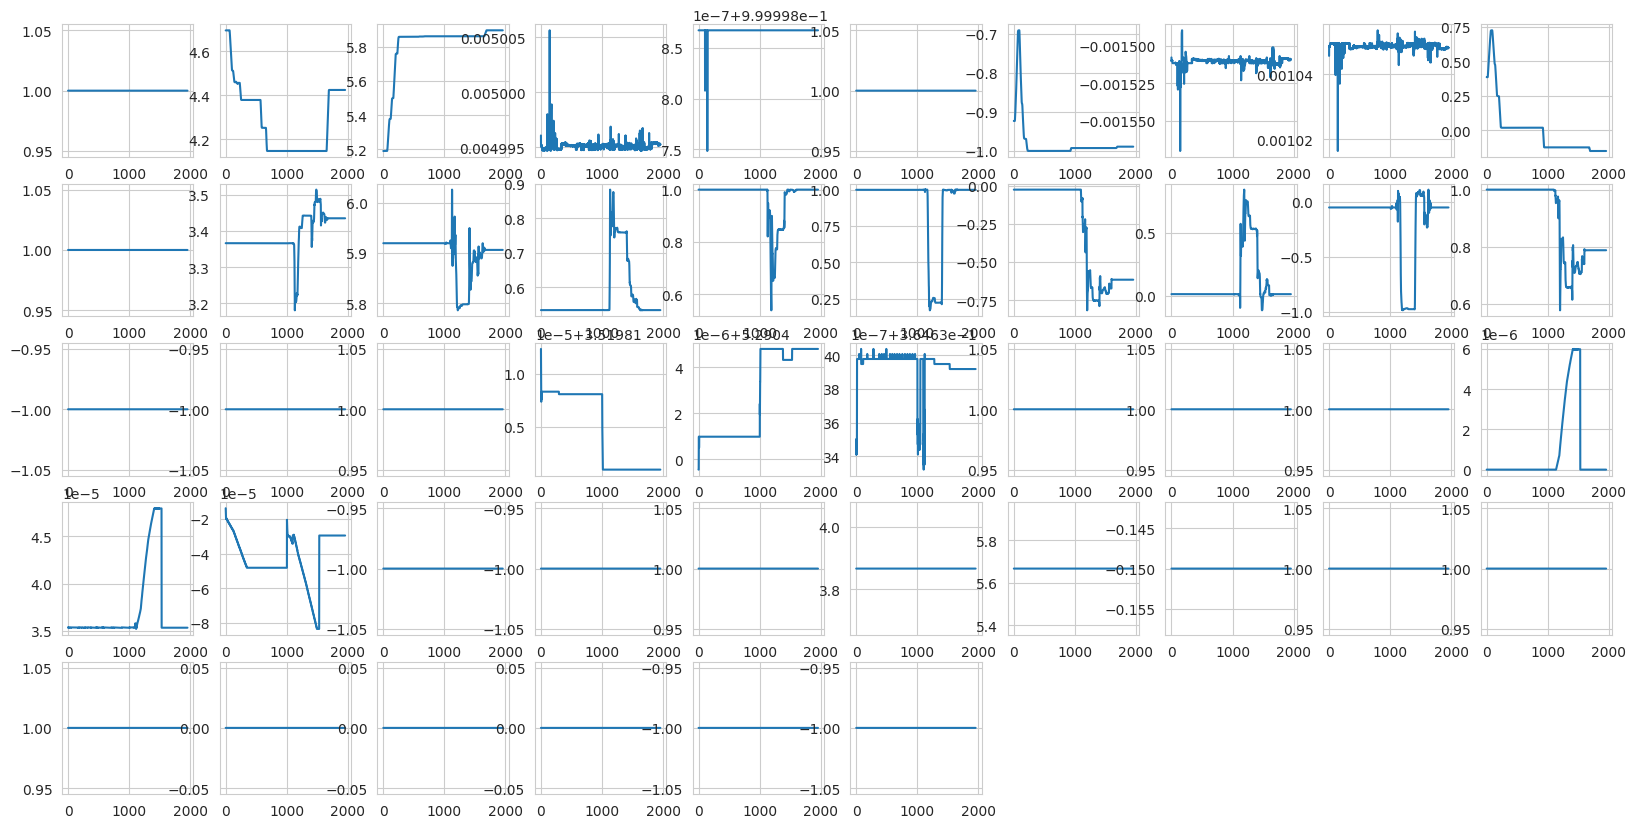

In [27]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

def viz_arr(column_data):
    l = len(column_data[0])
    data_array = np.array(column_data.tolist())
    rws = l  // 10 + 1

    fig, axes = plt.subplots(rws, 10, figsize=(20, 10))

    k = [axes.flat[i].plot(data_array[:, i]) or axes.flat[i].set_title(f'{i}', fontsize=8) if i < l else axes.flat[i].set_visible(False) for i in range(rws * 10)]

viz_arr(test_ep['observation.task_info']) 

In [24]:
type(data_array)

pandas.core.series.Series

In [2]:
import torch
import numpy as np
import pickle
import argparse
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from einops import rearrange
import copy

# from utils import sample_box_pose, sample_insertion_pose # robot functions
# from visualize_episodes import save_videos
from pdb import set_trace
import matplotlib.pyplot as plt
import math
from typing import Optional, List
import h5py
from torch.utils.data import DataLoader
from pathlib import Path

import torch.nn as nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torch import nn, Tensor

# from sim_env import make_sim_env, BOX_POSE
# from aim import Run

In [ ]:
dry_run = True

args = {
    'num_epochs': 10000,
    'eval_interval_epochs': 500,
    'num_eval_rollouts': 100,
    'lr_backbone': 1e-5,
    'batch_size': 8,
    'trained_model_dir': '../experiments/aloha/sim_transfer_cube_scripted/second_workstream/',
    'task_name': 'sim_transfer_cube_scripted',
    'dataset_dir': '../data/aloha/sim_transfer_cube_scripted',
    'chunk_size': 100,  # chunk_size is --> num_queries <-- !!!!
    'd_model': 512,  # d_model
    'dim_feedforward': 3200,
    'lr': 1e-5,
    'kl_weight': 10,
    'state_dim': 14,
    'num_episodes': 50,
    'episode_len': 400,
    'camera_names': ['top'],
    'num_encoder_layers': 4,
    'num_decoder_layers': 7,
    'backbone': 'resnet18',
    'nhead': 8,
    'weight_decay': 1e-4,
    'dropout': 0.1,
    'position_embedding': 'sine',
    'normalize_before': False,
    'fps': 50,
    'latent_dim': 32,
}

if dry_run:
    args.update({
        'num_epochs': 2,
        'num_eval_rollouts': 2,
    })

In [1]:
1

1